In [847]:
import cloudytab
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import astropy.units as u
import numpy as np
# sns.set_palette("magma", n_colors=3)

In [848]:
datapath = Path.cwd().parent / "cloudy"

Set up default property cycle for the three models

In [849]:
from cycler import cycler

# Define a custom property cycle
custom_cycler = (
    cycler(color=["xkcd:emerald green", "xkcd:bright blue", "xkcd:red"]) +
    cycler(linestyle=["-", "--", "-."]) +
    cycler(linewidth=[1.2, 1.5, 1.7])
)
plt.rc("axes", prop_cycle=custom_cycler)


## Three models that are identical apart from the abundances

In [850]:
suffixes = ["", "-Z6fluct-long", "-Z6fluct-short"]

Choose the model set to plot: `n-lha` is constant density, `p-lha` is constant pressure. Both are matched to the observed Ha luminosity of the nebula.

In [851]:
# model_id = "T115-L660-n-lha"
# model_id = "T115-L660-p-lha"
model_id = "T115-L660-n-llha"
# model_id = "T115-L660-p-llha"

In [852]:
models = [cloudytab.CloudyModel(datapath / f"ou5-{model_id}{s}") for s in suffixes]

In [853]:
models[0].data.keys()

dict_keys(['abun', 'rad', 'ems', 'cont', 'ovr', 'dr'])

### Select only the columns we need

In [854]:
models[0].data["ems"].columns

<TableColumns names=('depth','H  1 6562.80A','Ca B 6562.81A','H  1 4861.32A','He 2 4685.68A','He 2 6560.01A','He 1 5015.68A','O  3 5006.84A','O  3 4363.21A','O 3R 4363.00A','O  2 7319.99A','N  2 6583.45A','Ar 4 4711.26A','C  2 4267.00A','O  2 4651.00A','O  2 4094.00A','O  1 7771.94A')>

In [855]:
def get_plot_data(model):
    plot_data = {}
    plot_data["radius"] = model.data["rad"]["radius"] * u.cm.to(u.pc)
    plot_data["O/H"] = 10 ** (model.data["abun"]["OXYG"] - model.data["abun"]["abund H"])
    for _column in ["Te", "HeIII", "eden"]:
        plot_data[_column] = model.data["ovr"][_column]
    plot_data[r"e(H$\beta$)"] = model.data["ems"]["H  1 4861.32A"]
    plot_data[r"e(He II $\lambda$4686)"] = model.data["ems"]["He 2 4685.68A"]
    plot_data[r"e([O III] $\lambda$5007)"] = model.data["ems"]["O  3 5006.84A"]
    plot_data[r"e([O III] $\lambda$4363)"] = (
        model.data["ems"]["O  3 4363.21A"] + model.data["ems"]["O 3R 4363.00A"]
    )
    plot_data[r"e(O II $\lambda$4651)"] = model.data["ems"]["O  2 4651.00A"]
        
    return plot_data

In [856]:
datasets = [get_plot_data(m) for m in models]

In [857]:
peaks = ((10**16.698) * np.arange(6) * u.cm).to_value(u.pc) + datasets[0]["radius"][0]
peaks

array([0.06006784, 0.07623559, 0.09240333, 0.10857108, 0.12473882,
       0.14090657])

In [858]:
ylabel_dict = dict(y=0.5, rotation=0, ha="right", va="center")

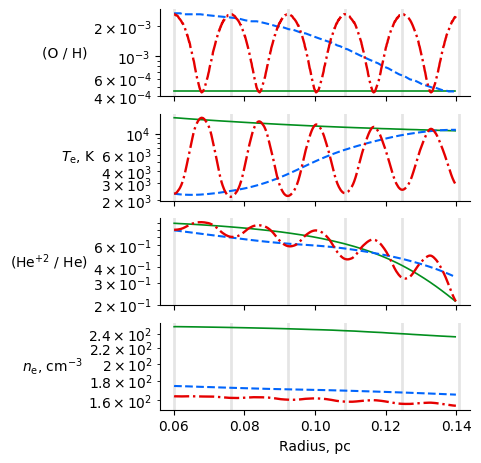

In [859]:
ny = 4
fig, axes = plt.subplots(ny, 1, sharex=True, figsize=(4, 1.3*ny))
for data in datasets:
    axes[0].plot("radius", "O/H", data=data)
    axes[0].set_ylabel("(O / H)", **ylabel_dict)
    axes[1].plot("radius", "Te", data=data)
    axes[1].set_ylabel(r"$T_\mathrm{e}$, K", **ylabel_dict)
    axes[2].plot("radius", "HeIII", data=data)
    axes[2].set_ylabel(r"(He$^{+2}$ / He)", **ylabel_dict)
    axes[3].plot("radius", "eden", data=data)
    axes[3].set_ylabel(r"$n_\mathrm{e}$, cm$^{-3}$", **ylabel_dict)
        

#axes[0].set_ylim(0, None)
# axes[0].set_yscale("log")

# axes[1].set_ylim(0, None)
# axes[1].set_yscale("log")

# axes[2].set_ylim(0, 1)

for ax in axes:
    ax.set_yscale("log")
    for peak in peaks:
        ax.axvline(peak, color="k", lw=2, alpha=0.1, zorder=-100)
        
sns.despine()
axes[-1].set_xlabel("Radius, pc")
fig.savefig(f"ou5-cloudy-{model_id}-physical.pdf", bbox_inches="tight")

In [860]:
emlines = [k for k in datasets[0].keys() if k.startswith("e(")]

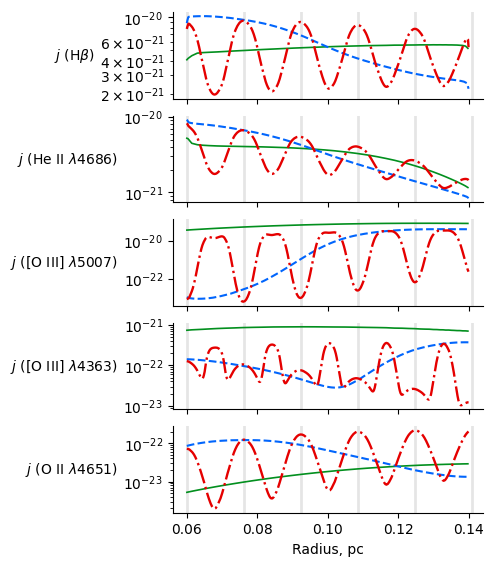

In [861]:
ny = len(emlines)
fig, axes = plt.subplots(ny, 1, sharex=True, figsize=(4, 1.3*ny))
for emline, ax in zip(emlines, axes):
    for data in datasets:
        ax.plot(data["radius"], data[emline])
    ax.set_ylabel(emline.replace("e(", r"$j$ ("), **ylabel_dict)

for ax in axes:
    # ax.set_ylim(None, None)
    # ymin, ymax = ax.get_ylim()
    # ax.set_ylim(ymax/200, ymax)
    ax.set_yscale("log")
    for peak in peaks:
        ax.axvline(peak, color="k", lw=2, alpha=0.1, zorder=-100)

axes[-1].set_xlabel("Radius, pc")
sns.despine()
fig.savefig(f"ou5-cloudy-{model_id}-emission.pdf", bbox_inches="tight")

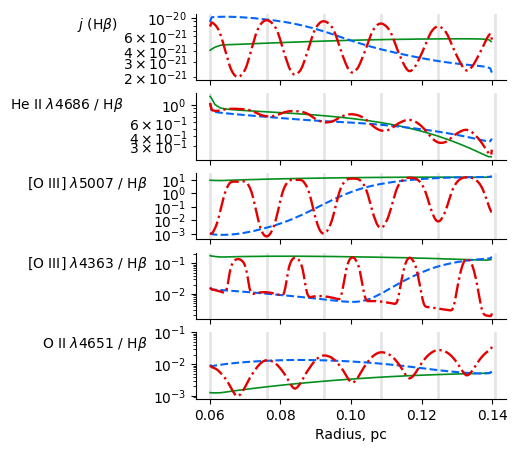

In [862]:
ny = len(emlines)
fig, axes = plt.subplots(ny, 1, sharex=True, figsize=(4, 1*ny))
for emline, ax in zip(emlines, axes):
    if "beta" in emline:
        for data in datasets:
            ax.plot(data["radius"], data[emline])
        ax.set_ylabel(emline.replace("e(", r"$j$ ("), y=0.7, rotation=0, ha="right")
    else:
        for data in datasets:
            ax.plot(data["radius"], data[emline] / data[r"e(H$\beta$)"])
        ax.set_ylabel(
            (emline
             .replace("e(", r"")
             .replace(")", r" / H$\beta$")
            ), 
            y=0.7, rotation=0, ha="right")

min_factor = 30
for ax in axes:
    # ax.set_ylim(0, None)
    ax.set_yscale("log")
    if ymax < min_factor * ymin:
        ax.set_ylim(ymax / min_factor, ymax)
    if "/" in ax.get_ylabel():
        ylmin, ylmax = [np.log10(_) for _ in ax.get_ylim()]
        lticks = np.arange(int(ylmin), int(ylmax+1))
        ax.set_yticks(10.0**lticks)
    #
    for peak in peaks:
        ax.axvline(peak, color="k", lw=2, alpha=0.1, zorder=-100)

axes[-1].set_xlabel("Radius, pc")
sns.despine()
fig.savefig(f"ou5-cloudy-{model_id}-eratios.pdf", bbox_inches="tight")

In [863]:
ax.get_ylim()

(0.000822788377535816, 0.1)

### Earlier version that plots all the emission lines

In [864]:
m0, mm, m = models

In [865]:
edata = m.data["ems"]
edata0 = m0.data["ems"]
edata1 = mm.data["ems"]

In [866]:
elines = list(edata.columns[1:])
elines

['H  1 6562.80A',
 'Ca B 6562.81A',
 'H  1 4861.32A',
 'He 2 4685.68A',
 'He 2 6560.01A',
 'He 1 5015.68A',
 'O  3 5006.84A',
 'O  3 4363.21A',
 'O 3R 4363.00A',
 'O  2 7319.99A',
 'N  2 6583.45A',
 'Ar 4 4711.26A',
 'C  2 4267.00A',
 'O  2 4651.00A',
 'O  2 4094.00A',
 'O  1 7771.94A']

In [867]:
radius = m.data["rad"]["radius"] * u.cm.to(u.pc)
radius0 = m0.data["rad"]["radius"] * u.cm.to(u.pc)
radius1 = mm.data["rad"]["radius"] * u.cm.to(u.pc)


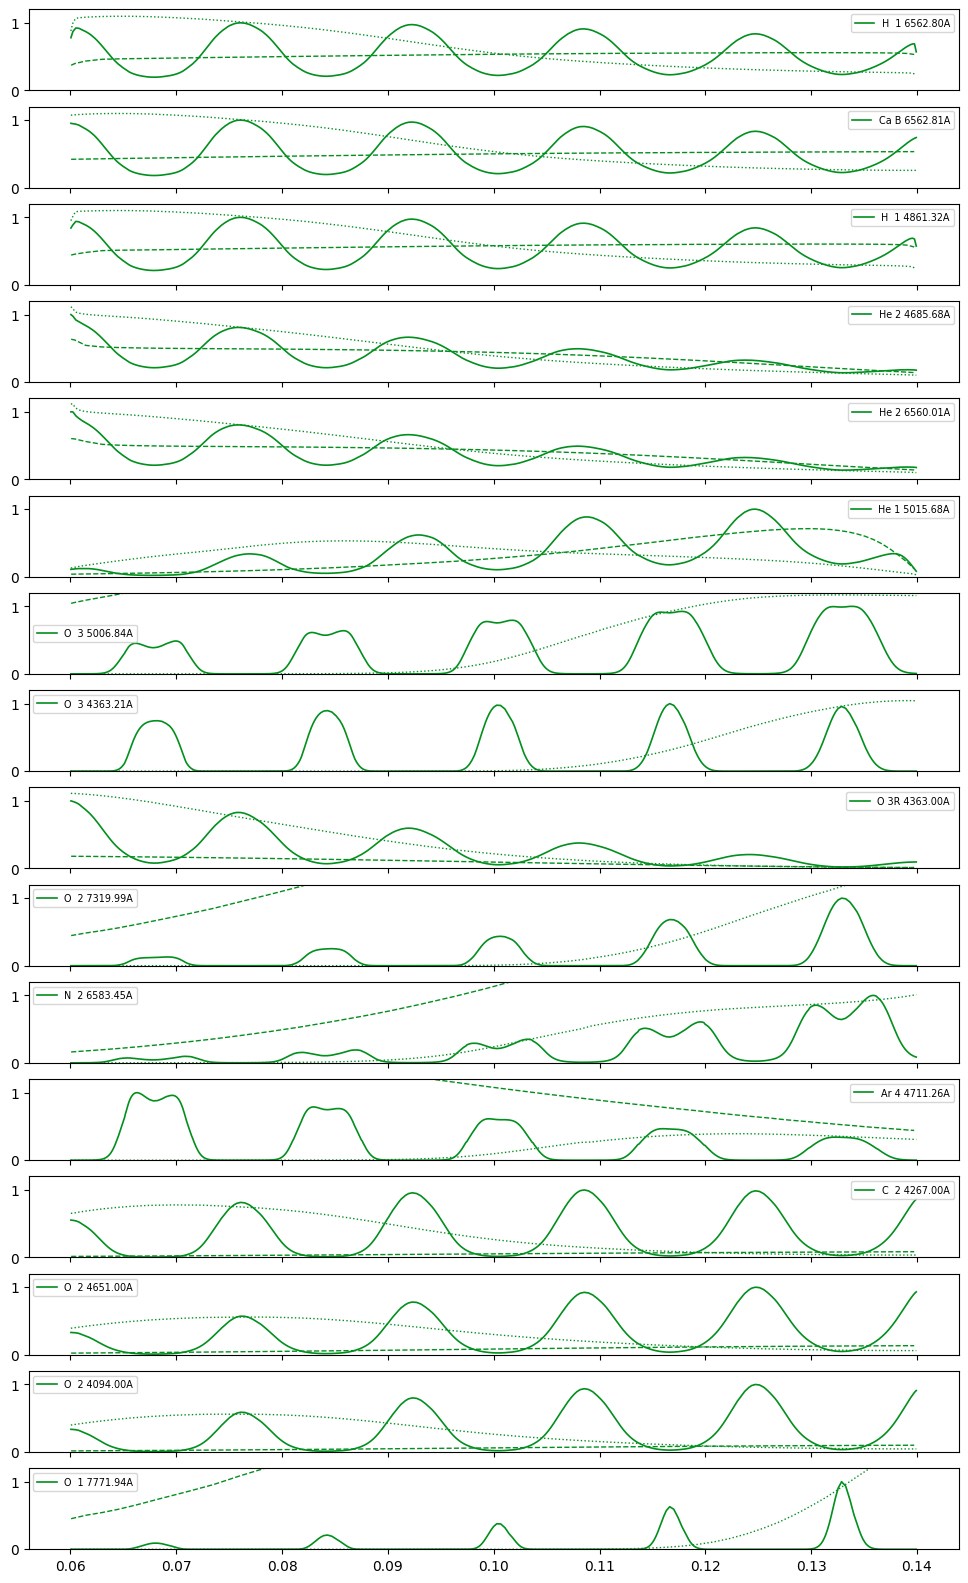

In [868]:
fig, axes = plt.subplots(len(elines), 1, figsize=(12, 20), sharex=True)
for ax, eline in zip(axes, elines):
    scale = edata[eline].max()
    # scale = 1
    line, = ax.plot(radius, edata[eline] / scale, label=eline)
    ax.plot(radius0, edata0[eline] / scale, label=None, color=line.get_color(), lw=1, ls="dashed")
    ax.plot(radius1, edata1[eline] / scale, label=None, color=line.get_color(), lw=1, ls="dotted")
    ax.set_yscale("linear")
    ax.set_ylim(0, 1.2)
    ax.legend(ncol=4, fontsize="x-small")